## Introduction

## Dataset
https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

## Objetivo
Prever a faixa de preço de um celular de acordo com características de hardware

## Dependências

In [ ]:
!pip install gradio
from fastai.imports import *
import gradio as gr

## Data preprocessing

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/mobile-price-classification')
else:
    import zipfile,kaggle
    path = Path('mobile-price-classification')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
# modes = df.mode().iloc[0]

print(f'Previsões possíveis da faixa de preço: ' + str(np.unique(df['price_range'])))
print('\n\n')
print(df.info())
print('\n\n')
print(df.head())

Previsões possíveis da faixa de preço: [0 1 2 3]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  

In [3]:
def proc_data(dfa):
    dfa['blue'] = pd.Categorical(dfa['blue'])
    dfa['dual_sim'] = pd.Categorical(dfa['dual_sim'])
    dfa['four_g'] = pd.Categorical(dfa['four_g'])
    dfa['n_cores'] = pd.Categorical(dfa['n_cores'])
    dfa['three_g'] = pd.Categorical(dfa['three_g'])
    dfa['touch_screen'] = pd.Categorical(dfa['touch_screen'])
    dfa['wifi'] = pd.Categorical(dfa['wifi'])

proc_data(df)

We'll make a list of the continuous, categorical, and dependent variables. Note that we no longer consider `Pclass` a categorical variable. That's because it's *ordered* (i.e 1st, 2nd, and 3rd class have an order), and decision trees, as we'll see, only care about order, not about absolute value.

In [4]:
categories=['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi']
conts = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

In [7]:
np.unique(df['price_range'])

array([0, 1, 2, 3])

## Binary splits

Before we create a Random Forest or Gradient Boosting Machine, we'll first need to learn how to create a *decision tree*, from which both of these models are built.

And to create a decision tree, we'll first need to create a *binary split*, since that's what a decision tree is built from.

A binary split is where all rows are placed into one of two groups, based on whether they're above or below some threshold of some column. For example, we could split the rows of our dataset into males and females, by using the threshold `0.5` and the column `Sex` (since the values in the column are `0` for `female` and `1` for `male`). We can use a plot to see how that would split up our data -- we'll use the [Seaborn](https://seaborn.pydata.org/) library, which is a layer on top of [matplotlib](https://matplotlib.org/) that makes some useful charts easier to create, and more aesthetically pleasing by default:

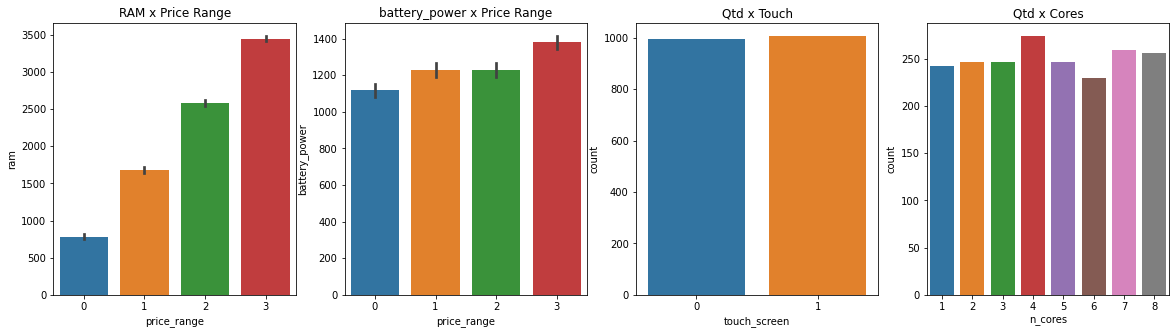

In [9]:
import seaborn as sns

fig,axs = plt.subplots(1,4, figsize=(20,5))
sns.barplot(data=df, y="ram", x="price_range", ax=axs[0]).set(title="RAM x Price Range")
sns.barplot(data=df, y="battery_power", x="price_range", ax=axs[1]).set(title="battery_power x Price Range")
sns.countplot(data=df, x="touch_screen", ax=axs[2]).set(title="Qtd x Touch");
sns.countplot(data=df, x="n_cores", ax=axs[3]).set(title="Qtd x Cores");

Here we see that (on the left) if we split the data into males and females, we'd have groups that have very different survival rates: >70% for females, and <20% for males. We can also see (on the right) that the split would be reasonably even, with over 300 passengers (out of around 900) in each group.

We could create a very simple "model" which simply says that all females survive, and no males do. To do so, we better first split our data into a training and validation set, to see how accurate this approach turns out to be:

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(29)

train_df,val_df = train_test_split(df, test_size=0.25)

train_df[categories] = train_df[categories].apply(lambda x: x.cat.codes)
val_df[categories] = val_df[categories].apply(lambda x: x.cat.codes)

train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
935,1231,0,0.7,1,2,0,7,0.9,113,0,...,43,1663,3119,9,4,15,1,1,0,3
906,1983,1,1.2,1,6,1,27,0.6,125,0,...,370,1197,3897,12,10,10,1,1,1,3
945,832,0,1.1,0,0,1,46,0.3,93,5,...,820,1366,3317,8,0,19,1,1,0,3
158,1356,0,2.8,0,0,0,29,0.5,198,5,...,1612,1983,3702,17,0,19,0,0,0,3
756,545,0,0.5,0,0,1,11,0.3,131,2,...,381,1452,616,15,6,19,1,1,1,0


(In the previous step we also replaced the categorical variables with their integer codes, since some of the models we'll be building in a moment require that.)

Now we can create our independent variables (the `x` variables) and dependent (the `y` variable):

In [11]:
def xs_y(df):
    xs = df[categories+conts].copy()
    return xs,df["price_range"] if "price_range" in df else None

train_xs,train_y = xs_y(train_df)
val_xs,val_y = xs_y(val_df)

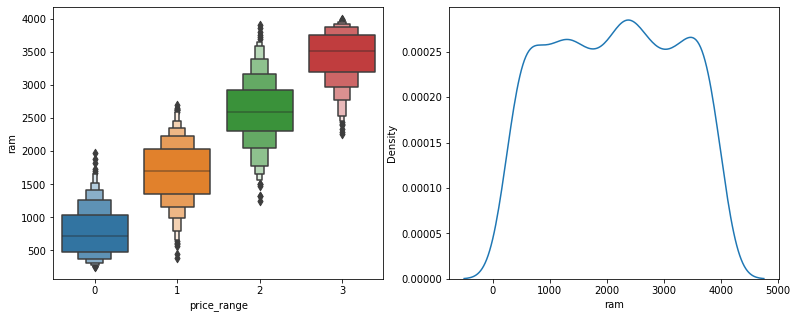

In [12]:
fig,axs = plt.subplots(1,2, figsize=(13,5))
sns.boxenplot(data=train_df, x="price_range", y="ram", ax=axs[0])
sns.kdeplot(data=train_df, x="ram", ax=axs[1]);

In [13]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Now we've got that written, we can calculate the score for a split by adding up the scores for the "left hand side" (lhs) and "right hand side" (rhs):

In [14]:
def score(col, y, split):
    lhs = col <= split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [16]:
def iscore(nm, split):
    col = train_xs[nm]
    return score(col, train_y, split)

from ipywidgets import interact
interact(nm=conts, split=1000)(iscore);

interactive(children=(Dropdown(description='nm', options=('battery_power', 'clock_speed', 'fc', 'int_memory', …

Try selecting different columns and split points using the dropdown and slider above. What splits can you find that increase the purity of the data?

We can do the same thing for the categorical variables:

In [17]:
interact(nm=categories, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', …

Based on this, it looks like, for instance, that for the `Age` column, `6` is the optimal cutoff according to our training set.

We can write a little function that implements this idea:

In [18]:
def min_col(df, nm):
    col,y = df[nm],df['price_range']
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

Let's try all the columns:

In [19]:
cols = categories+conts
{o:min_col(train_df, o) for o in cols}

{'blue': (1, 1.1231668037797153),
 'dual_sim': (1, 1.1231668037797153),
 'four_g': (1, 1.1231668037797153),
 'n_cores': (0, 1.123024983722014),
 'three_g': (0, 1.1231345459336797),
 'touch_screen': (0, 1.12264208281824),
 'wifi': (1, 1.1231668037797153),
 'battery_power': (1332, 1.0987327865949208),
 'clock_speed': (2.3, 1.1213608358831764),
 'fc': (18, 1.1221221952334135),
 'int_memory': (60, 1.121076746605277),
 'm_dep': (0.1, 1.1212062746226479),
 'mobile_wt': (190, 1.121759815005756),
 'pc': (15, 1.1220010340907283),
 'px_height': (1083, 1.1090485513696016),
 'px_width': (1643, 1.1050199054753953),
 'ram': (2253, 0.6357337615522403),
 'sc_h': (18, 1.1224797937316735),
 'sc_w': (10, 1.1214832895773958),
 'talk_time': (6, 1.1221195897877705)}

According to this, `ram<=2253` is the best split we can use.

We've just re-invented the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993. Since it's so simple and surprisingly effective, it makes for a great *baseline* -- that is, a starting point that you can use to compare your more sophisticated models to.

## Creating a decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(train_xs, train_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [21]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

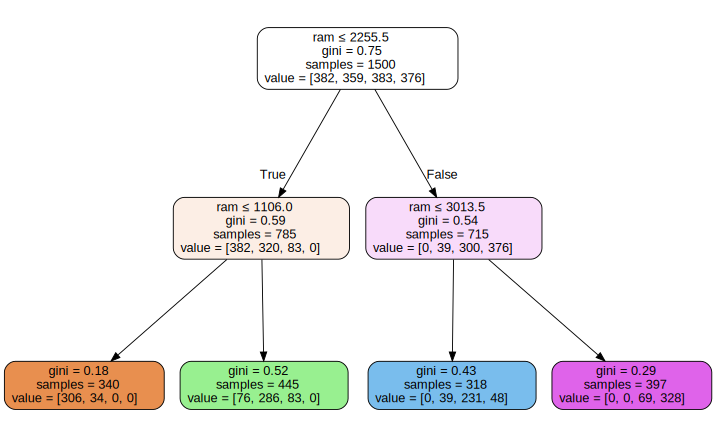

In [23]:
draw_tree(m, train_xs)

Let's see how this model compares to our OneR version:

In [24]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_y, m.predict(val_xs))

0.252

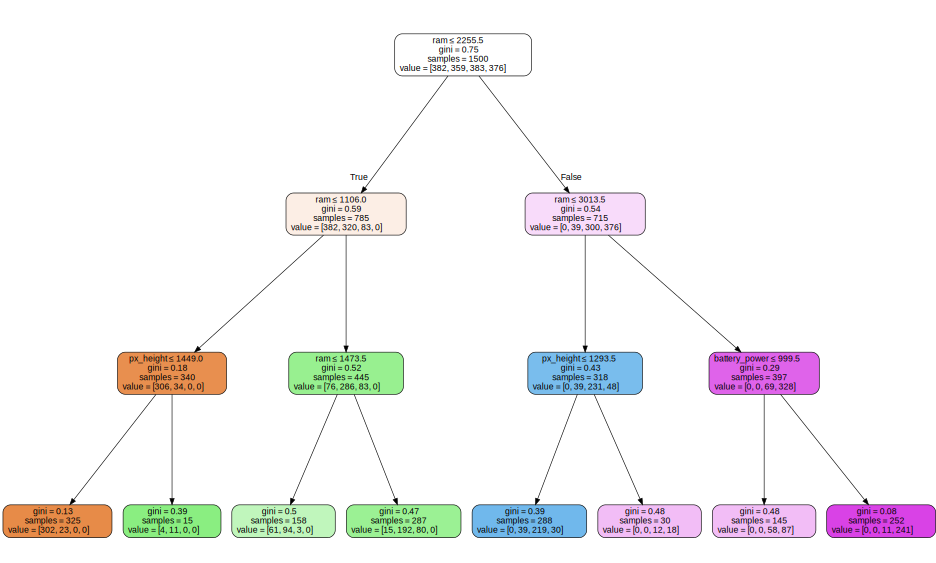

In [38]:
m = DecisionTreeClassifier(max_depth=3)
m.fit(train_xs, train_y)
draw_tree(m, train_xs, size=13)

In [25]:
mean_absolute_error(val_y, m.predict(val_xs))

0.252

## The random forest

We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them. That's not a lot of data to make a prediction.

So how could we use bigger trees? One big insight came from Leo Breiman: what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as [bagging](https://link.springer.com/article/10.1007/BF00058655).

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [26]:
def get_tree(prop=0.75):
    n = len(train_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(train_xs.iloc[idxs], train_y.iloc[idxs])

Now we can create as many trees as we want:

In [27]:
trees = [get_tree() for t in range(100)]

Our prediction will be the average of these trees' predictions:

In [28]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.18302

This is nearly identical to what `sklearn`'s `RandomForestClassifier` does. The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. Here's how we repeat the above process with a random forest:

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(train_xs, train_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.13

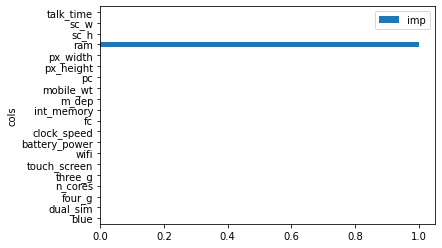

In [30]:
pd.DataFrame(dict(cols=train_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
import joblib

# Exportar o modelo treinado
joblib.dump(rf, 'modelo.pkl')

# Exportar valor base
base_item = val_xs.mode().iloc[0]
joblib.dump(base_item, 'base_item.pkl')

# Link para Hugging Face

[Aqui](https://huggingface.co/spaces/luisgaboardi/phone_price_range)